In [ ]:
%%capture --no-stderr
%!pip -q install langchain-core langchain-community langgraph langchain-openai duckduckgo-search yfinance

# Traditional ReAct Prompt

In [9]:
react_prompt = """Assistant is a large language model trained by Microsoft.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

TOOLS:
------

Assistant has access to the following tools:

wikipedia_search - searches the wikipedia database for the answer\n
web_search - searches the web for the answer\n
calculator - calculates the answer to the question\n
weather_api - gets the weather for the location\n


To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [wikipedia_search, web_search, calculator, weather_api]
Action Input: the input to the action
Observation: the result of the action
```

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: Do I need to use a tool? No
Final Answer: [your response here]
```

Begin!


New input: Whow was King Arthur?
"""

# Simple ReAct Agent Design

![react diagram](images/react-diagram.png)

In [23]:
import dotenv
dotenv.load_dotenv()

True

### Tools

In [24]:
# search tools
from custom_tools import add, multiply, divide
from langchain_community.tools import TavilySearchResults, DuckDuckGoSearchRun
from langchain_openai import ChatOpenAI

search = TavilySearchResults(max_results=2)
# search = DuckDuckGoSearchRun()
tools = [add, multiply, divide, search]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


In [25]:
search.invoke("How old is Brad Pitt?")

[{'url': 'https://nypost.com/2023/12/20/entertainment/brad-pitts-60th-birthday-paris-photos-with-girlfriend-ines-de-ramon/',
  'content': 'Brad Pitt rang in his six-decade milestone in a big way — twice! Pitt celebrated his 60th birthday on Monday, along with friends and his girlfriend, Ines de Ramon, 33, with "low key'},
 {'url': 'https://www.celebsagewiki.com/brad-pitt',
  'content': 'We recommend you to check the complete list of Famous People born on 18 December. He is a member of famous Actor with the age 60 years old group. Brad Pitt Height, Weight & Measurements. At 60 years old, Brad Pitt height is 5′ 11″ .'}]

## Nodes

In [26]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
                                "Provide your reasoning in an explicit `Thought` section before providing your response.")

# Node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


### Building the graph

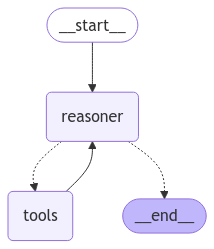

In [27]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [30]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})

In [31]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_oJZYX792TSkzf2VXp1OE25xy)
 Call ID: call_oJZYX792TSkzf2VXp1OE25xy
  Args:
    query: Brad Pitt age 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://people.com/brad-pitt-60th-birthday-party-details-pda-balloons-gifts-los-angeles-exclusive-8419170", "content": "Framed photo of Ines de Ramon and Brad Pitt at his birthday celebration in Los Angeles on Dec. 19, 2023. TheImageDirect.com Brad Pitt Goes Golden Cowboy for His 60th Birthday in Bold Western-Style"}, {"url": "https://en.wikipedia.org/wiki/Brad_Pitt", "content": "Pitt's next role, in 2001's $143 million-grossing Cold War thriller Spy Game,[32] was as Tom Bishop, an operative of the CIA's Special Activities

## More manual way and adding a custom tool

In [32]:
from custom_tools import get_stock_price
get_stock_price("TSLA")

389.22

In [34]:
tools = [add, multiply, divide, search, get_stock_price]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [35]:
from typing import Annotated, TypedDict, List
import operator
from langchain_core.messages import AnyMessage


class GraphState(TypedDict):
    """State of the graph."""
    query: str
    prices: list[str]
    final_answer: str
    messages: Annotated[list[AnyMessage], operator.add]


In [36]:
# Node
def reasoner(state):
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    original_query = HumanMessage(content=state["query"])
    messages.append(original_query)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages": result}


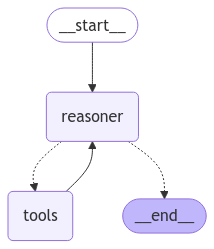

In [37]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode


# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [38]:
response = react_graph.invoke({"query": "What is 2 times the stock price of the company that Jensen Huang is CEO of?", "messages": []})

In [39]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_XCdgWcYYYCaLwDP5YUv7RVzx)
 Call ID: call_XCdgWcYYYCaLwDP5YUv7RVzx
  Args:
    query: Jensen Huang CEO company
  get_stock_price (call_FAhMsR2nrpticbyKp2WZXohU)
 Call ID: call_FAhMsR2nrpticbyKp2WZXohU
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.forbes.com/profile/jensen-huang/", "content": "Jensen Huang, the CEO of Nvidia, has the same caliber of vision and energy to drive his company to be like Apple, a multitrillion-dollar company. By Tim Bajarin Contributor Nov 7, 2024"}, {"url": "https://www.cbsnews.com/news/meet-nvida-ceo-jensen-huang-company-powering-ai-today-60-minutes-transcript/", 